<a href="https://colab.research.google.com/github/kunalavghade/Ai/blob/main/Week_7_%E2%80%94_Advanced_Optimization_Momentum%2C_RMSProp_%26_Adam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 7 — Advanced Optimization: Momentum, RMSProp & Adam

## Goal

Understand modern optimization algorithms used in deep learning.

By the end of this week, you should:
- Understand why plain gradient descent is inefficient
- Implement Momentum
- Implement RMSProp
- Implement Adam
- Compare optimizers empirically
- Understand convergence dynamics

---

# 1. Why Plain Gradient Descent Is Not Enough

Standard Gradient Descent:

θ = θ − α ∇L(θ)

Problems:
- Slow convergence
- Oscillation in ravines
- Sensitive to learning rate
- Same learning rate for all parameters

Neural network loss landscapes are:
- High-dimensional
- Non-convex
- Contain saddle points

We need smarter updates.

---

# 2. Momentum

## Intuition

Momentum accumulates past gradients to build velocity.

Like rolling a ball down a hill:
- It gains speed in consistent directions
- It damps oscillations

---

## Update Rule

v = βv + (1 − β)∇L  
θ = θ − αv

Where:
- β ∈ [0,1] (typically 0.9)
- v is velocity

Effects:
- Faster convergence
- Reduced zig-zag behavior
- Better traversal of narrow valleys

---

# 3. RMSProp

## Problem It Solves

Some parameters have:
- Large gradients
- Some have small gradients

Using same learning rate for all is inefficient.

---

## Idea

Scale learning rate per parameter using squared gradients.

---

## Update Rule

s = βs + (1 − β)(∇L)²  
θ = θ − α ∇L / (sqrt(s) + ε)

Where:
- s stores running average of squared gradients
- ε prevents division by zero

Effects:
- Adaptive learning rates
- Stabilizes training
- Works well in practice

---

# 4. Adam (Adaptive Moment Estimation)

Adam combines:
- Momentum (first moment)
- RMSProp (second moment)

It is the most commonly used optimizer.

---

## Update Rule

m = β₁m + (1 − β₁)∇L  
v = β₂v + (1 − β₂)(∇L)²  

Bias correction:

m̂ = m / (1 − β₁ᵗ)  
v̂ = v / (1 − β₂ᵗ)

Parameter update:

θ = θ − α m̂ / (sqrt(v̂) + ε)

Typical values:
- β₁ = 0.9
- β₂ = 0.999
- ε = 1e-8

---

# 5. Why Bias Correction?

At early steps:
- m and v are biased toward zero

Bias correction ensures:
- Proper scaling in initial iterations
- Faster warm-up phase

---

# 6. Comparing Optimizers

| Optimizer | Pros | Cons |
|-----------|------|------|
| SGD       | Simple | Slow |
| Momentum  | Faster | Still manual LR tuning |
| RMSProp   | Adaptive | May generalize worse |
| Adam      | Fast & stable | Can overfit |

Important research insight:
> Adaptive methods converge fast but sometimes generalize worse than SGD.

---

# 7. Geometry Perspective

Momentum:
- Smooths gradient trajectory

RMSProp:
- Rescales axes

Adam:
- Combines smoothing + rescaling

Optimization is about:
- Navigating curvature efficiently

---

# Coding Exercises (NumPy Only)

## Question 1: Implement Momentum

Modify your optimizer:
- Add velocity tracking
- Compare convergence vs plain SGD

Plot:
- Loss vs epochs
- Gradient norm vs epochs

---

## Question 2: Implement RMSProp

Add:
- Squared gradient accumulator
- Per-parameter scaling

Experiment:
- Different β values
- Observe stability

---

## Question 3: Implement Adam

Implement:
- m (first moment)
- v (second moment)
- Bias correction

Test on:
- XOR
- Simple regression

---

## Question 4: Optimizer Comparison Study

Train same model using:
- SGD
- Momentum
- RMSProp
- Adam

Compare:
- Convergence speed
- Final loss
- Stability

Plot all loss curves on same graph.

---

## Question 5: Learning Rate Sensitivity

For each optimizer:
- Try small α
- Try large α

Observe:
- Divergence
- Stability
- Speed

---

## Question 6: Conceptual (Write Answers)

1. Why does momentum reduce oscillation?
2. Why does RMSProp divide by sqrt(s)?
3. Why does Adam need bias correction?
4. Why might SGD generalize better than Adam?
5. When would you choose SGD over Adam?

---

# Outcome of Week 7

After completing this week, you should:
- Understand modern optimizers deeply
- Implement Adam from memory
- Know when to use which optimizer
- Think in terms of optimization geometry


In [1]:
import numpy as np
import matplotlib.pyplot as plt

Dataset (XOR)

In [2]:
X = np.array([[0,0],[0,1],[1,0],[1,1]], dtype=float)
y = np.array([[0],[1],[1],[0]], dtype=float)

imple 2-Layer MLP

We keep architecture fixed for fair optimizer comparison.

In [3]:
def relu(z): return np.maximum(z, 0)
def relu_derivative(z): return (z > 0).astype(float)
def sigmoid(z): return 1 / (1 + np.exp(-z))

Initialize

In [16]:
def initialize(layers):
    params = {}
    for l in range(1,len(layers)):
        params[f"W{l}"] = np.random.randn(layers[l-1], layers[l]) * np.sqrt(2/layers[l-1])
        params[f"b{l}"] = np.zeros((1,layers[l]))
    return params


Forward

In [21]:
def forward(X, params):
  A = X
  cache = {"A0": X}
  L = len(params)//2

  for l in range(1, L):
    Z = A @ params[f'W{l}'] + params[f'b{l}']
    A = relu(Z)

    cache[f'A{l}'] = A
    cache[f'Z{l}'] = Z

  ZL = A @ params[f'W{L}'] + params[f'b{L}']
  AL = sigmoid(ZL)
  cache[f'A{L}'] = AL
  return AL, cache

Backward

In [5]:
def backward(x, params, cache):
  grads = {}
  L = len(params) // 2
  m = y.shape[0]

  dZ = cache[f'A{L}'] - y

  for l in reversed(range(1, L+1)):
    A_prev = cache[f'A{l-1}']
    grads[f'dW{l}'] = (A_prev.T @ dZ) / m
    grads[f'db{l}'] = np.mean(dZ, axis=0, keepdims=True)

    if l > 1:
      dA = dZ @ params[f'W{l}'].T
      dz = dA * relu_derivative(cache[f'Z{l-1}'])
  return grads

**Optimizers**

3.1 SGD

In [6]:
def update_sgd(params, grads, lr):
  for key in params:
    params[key] -= lr * grads["d"+key]
  return params

3.2 Momentum

In [24]:
def init_momentum(params):
  v = {}
  for key in params:
    v[key] = np.zeros_like(params[key])
  return v

def update_momentum(params, grads, v, lr, beta=0.9):
  for key in params:
    v[key] = beta * v[key] + (1 - beta) * grads['d'+key]
    params[key] -= lr * v[key]
  return params, v

3.3 RMSProp

In [30]:
def init_rmsprop(params):
  s = {}
  for key in params:
    s[key] = np.zeros_like(params[key])
  return s

def update_rmsprop(params, grads, s, lr, beta=0.9, eps=1e-8):
  for key in params:
    s[key] = beta * s[key] + (1-beta) * (grads['d'+key]**2)
    params[key] -= lr * grads["d"+key] / np.sqrt(s[key] + eps)

  return params, s

3.4 Adam

In [39]:
def init_adam(params):
  m, v = {}, {}
  for key in params:
    m[key] = np.zeros_like(params[key])
    v[key] = np.zeros_like(params[key])
  return m, v

def update_adam(params, grads, m, v, t, lr = 0.01, beta1 = 0.9, beta2=0.999, eps=1e-8):
  for key in params:
    m[key] = beta1 * m[key] + (1 - beta1) * grads["d"+key]
    v[key] = beta2 * v[key] + (1 - beta2) * (grads["d"+key]**2)

    m_hat = m[key] / (1 - beta1 ** t)
    v_hat = v[key] / (1 - beta2 ** t)

    params[key] -= lr * m_hat / (np.sqrt(v_hat) + eps)
  return params, m, v

Training Wrapper

In [37]:
def train_optimizer(optimizer, layer, epochs=1000, lr=0.1):
  params = initialize(layers)
  losses = []

  if optimizer == "momentum":
    v = init_momentum(params)

  if optimizer == "rmsprop":
    s = init_rmsprop(params)

  if optimizer == "adam":
    m, v = init_adam(params)

  for t in range(1, epochs+1):
    y_hat, cache = forward(X, params)
    loss = -np.mean(y * np.log(y_hat + 1e-8) + (1-y) * np.log(1-y_hat+1e-8))
    losses.append(loss)

    grads = backward(y, params, cache)

    if optimizer == "sgd":
      params = update_sgd(params, grads, lr)

    elif optimizer == "momentum":
        params, v = update_momentum(params, grads, v, lr)

    elif optimizer == "rmsprop":
        params, s = update_rmsprop(params, grads, s, lr)

    elif optimizer == "adam":
        params, m, v = update_adam(params, grads, m, v, t, lr)

  return losses

Optimizer Comparison Plot

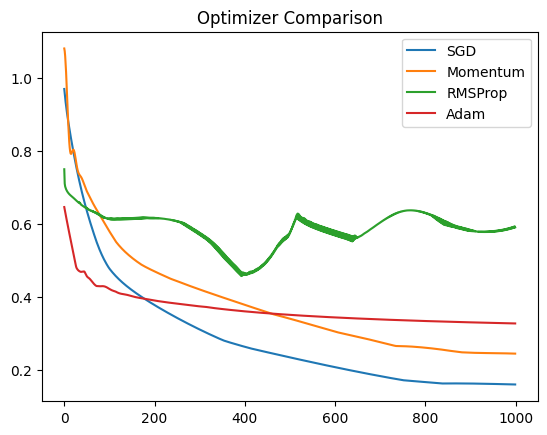

In [40]:
layers = [2,16,1]

loss_sgd = train_optimizer("sgd", layers, lr=0.1)
loss_mom = train_optimizer("momentum", layers, lr=0.1)
loss_rms = train_optimizer("rmsprop", layers, lr=0.01)
loss_adam = train_optimizer("adam", layers, lr=0.01)

plt.plot(loss_sgd,label="SGD")
plt.plot(loss_mom,label="Momentum")
plt.plot(loss_rms,label="RMSProp")
plt.plot(loss_adam,label="Adam")

plt.legend()
plt.title("Optimizer Comparison")
plt.show()



Learning Rate Sensitivity

/tmp/ipython-input-974347014.py:3: RuntimeWarning: overflow encountered in exp
  def sigmoid(z): return 1 / (1 + np.exp(-z))


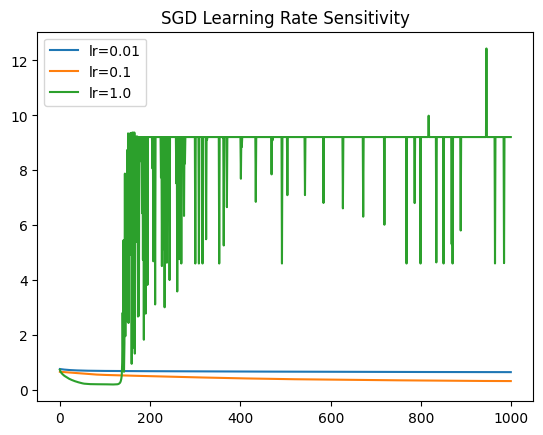

In [42]:
for lr in [0.01, 0.1, 1.0]:
    loss = train_optimizer("sgd", layers, lr=lr)
    plt.plot(loss,label=f"lr={lr}")

plt.legend()
plt.title("SGD Learning Rate Sensitivity")
plt.show()
